# To calibration the polarizer and analyzer angle

In [8]:
from cProfile import label
from cmath import exp, pi
from numpy import tan, sin, sqrt,cos
from re import A
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as npy
from scipy.signal import savgol_filter
from matplotlib.pyplot import MultipleLocator
from iminuit import Minuit
import iminuit
from iminuit.cost import LeastSquares
# import latex
# plt.style.reload_library()
plt.style.use(['science'])
# plt.style.use(['science','ieee'])
# plt.style.use(['science','no-latex'])

## The dark current

In [9]:
def currentDark(filename):
    inputfile=open(filename,'r')
    measurement_dark=[]
    monitor_dark=[]
    while(1):
        try:
            temp=next(inputfile).split()
            if(temp[4]=='dark'):
                measurement_dark.append(1e6*float(temp[2]))
            elif(temp[4]=='dark1'):
                monitor_dark.append(1e6*float(temp[2]))
        except StopIteration:
            break
    dark_meansurement=npy.mean(npy.array(measurement_dark))
    dark_monitor=npy.mean(npy.array(monitor_dark))
    return dark_meansurement,dark_monitor
dark_measurement,dark_monitor = currentDark('measurement_dark.txt')

## Define class and fit function

In [10]:
def calculate_index(phi,delta):
    phi=float(phi*pi/180)
    delta=float(delta*pi/180)
    anglei=65/180*pi
    rho=tan(phi)*exp(delta*1j)
    n1=1.
    # print('rho',rho)
    epsilon= (n1**2) * (sin(anglei)**2) * ( 1+(tan(anglei)**2)*((1-rho)/(1+rho))**2) 
    ep_re=epsilon.real
    ep_im=epsilon.imag
    n2=(1./sqrt(2.) * sqrt( sqrt(ep_re**2+ep_im**2) +ep_re)).real
    k2=(1./sqrt(2.) * sqrt( sqrt(ep_re**2+ep_im**2) -ep_re)).real
    return n2,k2

def intensityFun(t,scale,a,b,w): #define fit function
    phi=w*t
    # return a0+a1*npy.cos(2*phi)
    return (1+a*npy.cos(2*phi)+ b*npy.sin(2*phi))*scale

class dataVar:
    def __init__(self,angleP):
        self.angleP=angleP
        self.current=[]
        self.time=[]
        self.angleA=[]

def reader(filename,angleP,use):
    data=dataVar(angleP)
    inputfile=open(filename,'r')
    i=0
    while(1):
        try:
            temp=next(inputfile).split()
            if(temp[4]!=('P'+str(angleP))):
                continue
            data.time.append(i*0.5)
            if(use=='measurement'):
                data.current.append(1e6*float(temp[2])-dark_measurement)
            elif(use=='monitor'):
                data.current.append(1e6*float(temp[2])-dark_monitor)
            i=i+1
        except StopIteration:
            break
    return data

## Calculate a series of $\alpha$ and $\beta$ for future fit

[0.1474310054406367, 0.1410774491249127, 0.13762965495294432, 0.13420384386391493, 0.1339698255990256, 0.13297412785248175, 0.13442864129218268, 0.1403346513093049, 0.14475153524735695, 0.15506282448923236, 0.1776683123500371]
[0.04095737006803318, 0.03532186816696921, 0.028174781141548824, 0.024034114388985128, 0.019144307520851885, 0.016665830214326896, 0.015925353584286334, 0.01850191252791229, 0.0290951708217975, 0.034086526472669326, 0.05056820868190603]


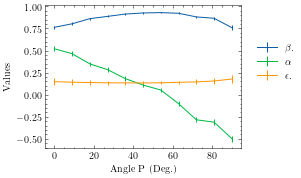

In [15]:
a=[3,0,3,3,0,2,1,1,1,2,2]  # the delay time of two Ammeters 
w0=0.035   # this is the estimated angular velocity
alpha=[]
alpha_err=[]
beta=[]
beta_err=[]
epsilon=[]
epsilon_err=[]
angleP=[]
angleP_radian=[]

for ip in range(11):
    angleA=[]
    angleP_temp=ip*9    #in degree
    angleP.append(angleP_temp)
    angleP_radian.append(angleP_temp/180*pi)
    window=10
    
    data_measurement=reader('measurement_caliAP.txt',angleP_temp,'measurement')
    data_monitor=reader('monitor_caliAP.txt',angleP_temp,'monitor')

    length=len(data_monitor.current)-20
    # print(length)
    b=0
    data_monitor.time=data_monitor.time[0:length]
    data_monitor.current=data_monitor.current[0+a[ip]:length+a[ip]]
    data_measurement.time=data_measurement.time[0:length]
    data_measurement.current=data_measurement.current[0+b:length+b]

    signal=npy.array(data_measurement.current)/npy.array(data_monitor.current)
    signal=savgol_filter(signal,window,3)  # Filtering operation
    # average of the end current
    mean_end=npy.mean(signal[720:])
    end_time=0
    for t in range(200):
        if(signal[680+t]>=mean_end):
            if(ip==10):
                end_time=680+t-6
            elif(ip==8):
                end_time=680+t-9
            else:
                end_time=680+t
            break
        else:
            continue
    
    signal_cut=npy.array(signal[0:end_time])
    signal_err=npy.sqrt(signal_cut)
    time_cut=npy.array(data_measurement.time[0:end_time])

    fig,ax=plt.subplots(2,1,sharex=True)
    ax[1].set_xlabel('Time (s)')
    ax[0].set_ylabel('Intensity')
    # ax[0].set_ylim()
    ax[0].plot(data_measurement.time,signal,label='Water 400nm',linewidth=1,color='orange')#,color='blue)
    ax[0].plot(time_cut,signal_cut,label='After cut',linestyle="--",color='k',linewidth=1)#,color='blue)
    ax[1].set_ylabel('Current (uA)')
    ax[1].plot(data_measurement.time,data_measurement.current,label='measurement')
    ax[1].plot(data_monitor.time,data_monitor.current,label='monitor')
    fig.suptitle(str(ip*9)+' Deg. Intensity Vs. Time')
    fig.subplots_adjust(hspace=0.1)
    fig.patch.set_facecolor('white')
    ax[0].legend()
    ax[1].legend()
    plt.close()
    fig.savefig('cali_figure/'+ str(ip*9)+ 'DegIntensityVsTime.png',dpi=1000)
    
    #time_cut and signal_cut ,signal_err is the x y yerr we need to fit.
    time_cut=time_cut-0.5*(len(time_cut)-1)
    least_squares=LeastSquares(time_cut,signal_cut,signal_err,intensityFun)
    m=Minuit(least_squares,scale=0,a=0,b=0,w=w0)
    m.limits[3]=(w0-0.005,w0+0.005)
    # m.limits[4]=(-0.3,0.3)
    m.migrad()
    m.hesse()
    para=m.values
    err=m.errors
    # p0=[0,0,0,w]
    # para,_=curve_fit(intensityFun,time_cut,signal_cut,p0)
    # print(para)
    # print(err)
    alpha.append(para[1])
    alpha_err.append(err[1])
    beta.append(para[2])
    beta_err.append(err[2])
    epsilon.append(1-para[1]**2-para[2]**2)
    epsilon_err.append(sqrt(4*para[1]**2*err[1]**2+4*para[2]**2*err[2]**2).real)
    signal_fit=intensityFun(time_cut,*para)
    ratio_fit=signal_cut/signal_fit
    fig,ax=plt.subplots(2,1,sharex=True)
    fit_info = [
        f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(time_cut) - m.nfit}",
        ]
    for p, v, e in zip(m.parameters, m.values, m.errors):
        fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    ax[1].set_xlabel('Time (s)')
    ax[0].set_ylabel('Intensity')
    ax[0].plot(time_cut,signal_cut,label='Ori. signal',linewidth=1,color='orange')#,color='blue)
    ax[0].plot(time_cut,signal_fit,label='Fitted signal',linestyle="--",color='k',linewidth=1)#,color='blue)
    ax[1].set_ylabel('Ratio')
    ax[1].plot(time_cut,ratio_fit,'.',label='Ori. Vs. Fitted',markersize=1)
    plt.fill_between(time_cut,npy.mean(ratio_fit)+npy.std(ratio_fit),npy.mean(ratio_fit)-npy.std(ratio_fit),alpha=0.3)
    ax[1].fill
    fig.legend(title="\n".join(fit_info),bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
    fig.suptitle(str(ip*9)+' Deg. Fit Result')
    # ax[0].legend(title="\n".join(fit_info))
    # ax[0].legend()
    # ax[1].legend()
    fig.patch.set_facecolor('white')
    fig.savefig('cali_figure/Fit'+ str(ip*9)+ 'DegIntensityVsTime.png',dpi=1000)
    plt.close()
print(epsilon)
print(epsilon_err)
fig,ax=plt.subplots()
ax.errorbar(angleP,beta,beta_err,label='$\\beta$.',linewidth=1)#''',color='orange')'''#,color='blue)
ax.errorbar(angleP,alpha,alpha_err,label='$\\alpha$',linewidth=1)#,color='orange')#,color='blue)
ax.errorbar(angleP,epsilon,epsilon_err,label='$\\epsilon$.',linewidth=1)#,color='orange')#,color='blue)
ax.set_xlabel('Angle P (Deg.)')
ax.set_ylabel('Values')
fig.legend(bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
fig.patch.set_facecolor('white')
fig.savefig('cali_figure/alphabeta.png',dpi=1000)


## Fit the P and epsilon with angleP epsilon and epsilon_err

In [16]:
def residualFun(P,phi,delta,Ps,As,eta):
    # eta=1
    As_radian=As/180*pi
    Ps_radian=Ps/180*pi
    phi_radian=phi/180*pi
    delta_radian=delta/180*pi
    a1=( ( tan(phi_radian) )**2-( tan(P-Ps_radian) )**2 )/( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    b1=( 2*tan(phi_radian)*cos(delta_radian)*tan(P-Ps_radian) ) /( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    a = 1/eta * ( a1*cos(2*As_radian)-b1*sin(2*As_radian) )
    b = 1/eta * ( a1*sin(2*As_radian)+b1*cos(2*As_radian) )
    return 1-a**2-b**2

def betaFun(P,phi,delta,Ps,As,eta):
    As_radian=As/180*pi
    Ps_radian=Ps/180*pi
    phi_radian=phi/180*pi
    delta_radian=delta/180*pi
    a1=( ( tan(phi_radian) )**2-( tan(P-Ps_radian) )**2 )/( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    b1=( 2*tan(phi_radian)*cos(delta_radian)*tan(P-Ps_radian) ) /( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    return  1/eta * ( a1*sin(2*As_radian)+b1*cos(2*As_radian) )

def alphaFun(P,phi,delta,Ps,As,eta):
    As_radian=As/180*pi
    Ps_radian=Ps/180*pi
    phi_radian=phi/180*pi
    delta_radian=delta/180*pi
    a1=( ( tan(phi_radian) )**2-( tan(P-Ps_radian) )**2 )/( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    b1=( 2*tan(phi_radian)*cos(delta_radian)*tan(P-Ps_radian) ) /( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    return  1/eta * ( a1*cos(2*As_radian)-b1*sin(2*As_radian) )


# Define the fit method

┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ phi   │    22     │     4     │            │            │         │         │       │
│ 1 │ delta │   -24.3   │    0.8    │            │            │         │         │       │
│ 2 │ Ps    │    27     │     5     │            │            │   -90   │   90    │       │
│ 3 │ As    │    -0     │    90     │            │            │   -90   │   90    │       │
│ 4 │ eta   │ 1000.0e-3 │  0.5e-3   │            │            │    0    │    1    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+

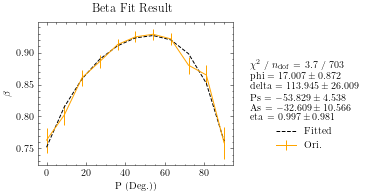

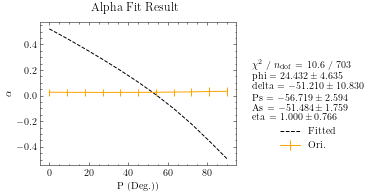

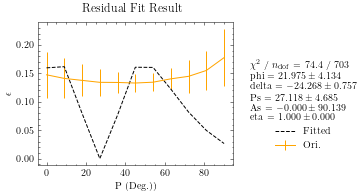

In [19]:
least_squares_residual=LeastSquares(angleP_radian,epsilon,epsilon_err,residualFun)
least_squares_beta=LeastSquares(angleP_radian,beta,beta_err,betaFun)
least_squares_alpha=LeastSquares(angleP_radian,alpha,alpha_err,alphaFun)
# let the beta fit first

m_beta=Minuit(least_squares_beta,phi=18,delta=-1,Ps=0,As=0,eta=1)
# m.limits[0]=(-90,90)
# m.limits[1]=(-90,90)
m_beta.limits[2]=(-90,90)
m_beta.limits[3]=(-90,90)
m_beta.limits[4]=(0,1)
# m.fixed['eta']=True
m_beta.migrad()
m_beta.hesse()
# then lets fit the residual
m_residual=Minuit(least_squares_residual,phi=18,delta=-1,Ps=0,As=0,eta=1)
m_residual.limits[2]=(-90,90)
m_residual.limits[3]=(-90,90)
m_residual.limits[4]=(0,1)
m_residual.migrad()
m_residual.hesse()

m_alpha=Minuit(least_squares_alpha,phi=18,delta=-1,Ps=0,As=0,eta=1)
m_alpha.limits[2]=(-90,90)
m_alpha.limits[3]=(-90,90)
m_alpha.limits[4]=(0,1)
m_alpha.migrad()
m_alpha.hesse()
# m.minos()
epsilon_fit=residualFun(npy.array(angleP_radian),*m_residual.values)
beta_fit=betaFun(npy.array(angleP_radian),*m_beta.values)
alpha_fit=alphaFun(npy.array(angleP_radian),*m_alpha.values)


fig,ax=plt.subplots()
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_beta.fval:.1f} / {len(time_cut) - m_beta.nfit}",
    ]
for p, v, e in zip(m_beta.parameters, m_beta.values, m_beta.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
ax.set_xlabel('P (Deg.))')
ax.set_ylabel('$\\beta$')
# ax.errorbar(angleP,epsilon,epsilon_err,label='Ori.',linewidth=1,color='orange')#,color='blue)
ax.errorbar(angleP,beta,beta_err,label='Ori.',linewidth=1,color='orange')#,color='blue)
ax.plot(angleP,beta_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
# ax.plot(angleP,epsilon_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
# ax.set_ylabel('Ratio')
# ax.plot(time_cut,ratio_fit,'.',label='Ori. Vs. Fitted',markersize=1)
# plt.fill_between(time_cut,npy.mean(ratio_fit)+npy.std(ratio_fit),npy.mean(ratio_fit)-npy.std(ratio_fit),alpha=0.3)
# ax[1].fill
fig.legend(title="\n".join(fit_info),bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
fig.suptitle('Beta Fit Result')
# fig.suptitle('Beta Fit Result')
# ax[0].legend(title="\n".join(fit_info))
# ax[0].legend()
# ax[1].legend()
fig.patch.set_facecolor('white')
fig.savefig('cali_figure/BetaFit.png',dpi=1000)

fig,ax=plt.subplots()
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_alpha.fval:.1f} / {len(time_cut) - m_alpha.nfit}",
    ]
for p, v, e in zip(m_alpha.parameters, m_alpha.values, m_alpha.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
ax.set_xlabel('P (Deg.))')
ax.set_ylabel('$\\alpha$')
# ax.errorbar(angleP,epsilon,epsilon_err,label='Ori.',linewidth=1,color='orange')#,color='blue)
ax.errorbar(angleP,alpha_err,alpha_err,label='Ori.',linewidth=1,color='orange')#,color='blue)
ax.plot(angleP,alpha_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
# ax.plot(angleP,epsilon_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
# ax.set_ylabel('Ratio')
# ax.plot(time_cut,ratio_fit,'.',label='Ori. Vs. Fitted',markersize=1)
# plt.fill_between(time_cut,npy.mean(ratio_fit)+npy.std(ratio_fit),npy.mean(ratio_fit)-npy.std(ratio_fit),alpha=0.3)
# ax[1].fill
fig.legend(title="\n".join(fit_info),bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
fig.suptitle('Alpha Fit Result')
# fig.suptitle('Beta Fit Result')
# ax[0].legend(title="\n".join(fit_info))
# ax[0].legend()
# ax[1].legend()
fig.patch.set_facecolor('white')
fig.savefig('cali_figure/AlphaFit.png',dpi=1000)

fig,ax=plt.subplots()
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_residual.fval:.1f} / {len(time_cut) - m_residual.nfit}",
    ]
for p, v, e in zip(m_residual.parameters, m_residual.values, m_residual.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
ax.set_xlabel('P (Deg.))')
ax.set_ylabel('$\\epsilon$')
ax.errorbar(angleP,epsilon,epsilon_err,label='Ori.',linewidth=1,color='orange')#,color='blue)
# ax.errorbar(angleP,beta,beta_err,label='Ori.',linewidth=1,color='orange')#,color='blue)
# ax.plot(angleP,beta_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
ax.plot(angleP,epsilon_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
# ax.set_ylabel('Ratio')
# ax.plot(time_cut,ratio_fit,'.',label='Ori. Vs. Fitted',markersize=1)
# plt.fill_between(time_cut,npy.mean(ratio_fit)+npy.std(ratio_fit),npy.mean(ratio_fit)-npy.std(ratio_fit),alpha=0.3)
# ax[1].fill
fig.legend(title="\n".join(fit_info),bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
fig.suptitle('Residual Fit Result')
# fig.suptitle('Beta Fit Result')
# ax[0].legend(title="\n".join(fit_info))
# ax[0].legend()
# ax[1].legend()
fig.patch.set_facecolor('white')
fig.savefig('cali_figure/ResidualFit.png',dpi=1000)

print(m_residual.params)
print(m_beta.params)
print(m_alpha.params)
# plt.close()